In [38]:
!pip install git+https://github.com/kunguz/odak.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kunguz/odak.git to /tmp/pip-req-build-eqrj83uq
  Running command git clone -q https://github.com/kunguz/odak.git /tmp/pip-req-build-eqrj83uq


In [39]:
import odak
import torch 
import numpy as np 
import sys
import odak.learn.raytracing as ODL
import matplotlib.pyplot as plt
import math
import odak.raytracing as raytracer
import odak.tools as tools
import odak.raytracing as raytracer
from odak.raytracing.ray import create_ray
import cv2
import sys
import torch.optim as optim

In [81]:
import sys
class aperture_array():

  def __init__(self, device, image):
    self.device = device
    self.image =image.to(device).view(-1,1)
    self.init_light_sources()
    self.init_aperture_array()
    self.init_detector()
  
  def init_light_sources(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.):
      x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
      y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
      X, Y = torch.meshgrid(x, y, indexing='ij')
      self.light_source_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
      self.light_source_locations[:, :, 0] = X
      self.light_source_locations[:, :, 1] = Y
      self.light_source_locations[:, :, 2] = Z
      
      
  def init_aperture_array(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.01):
        x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
        y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
        X, Y = torch.meshgrid(x, y, indexing='ij')
        self.aperture_array_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
        self.aperture_array_locations[:, :, 0] = X
        self.aperture_array_locations[:, :, 1] = Y
        self.aperture_array_locations[:, :, 2] = Z
        self.aperture_array = torch.rand(X.shape[0], X.shape[1], requires_grad=True).to(self.device) # makes it differentiable

        
        
  def init_detector(self, dimensions=[0.01, 0.015], pixel_count=[20, 30], Z=0.01):
        points = torch.tensor([0., 0, Z]).to(self.device)
        self.detector_surface = odak.learn.raytracing.define_plane(points)
        
        # Locations of my pixels on my detector could be defined here.
        
  def intersection_points_to_image(self, points, amplitudes):
   
        Points_data= self.image/amplitudes
        detector = torch.zeros_like(Points_data)

        for idx, point in enumerate(points):
          dist_btwn_array_npoint = torch.sqrt(torch.sum((self.aperture_array_locations-point)**2, dim=1))
          min_dist_idx  = torch.argmin(dist_btwn_array_npoint)
          
          detector[min_dist_idx] = Points_data[idx]
        detector= detector.view(20,30)
        return detector
  
  def forward(self):
        light_source_locations = self.light_source_locations.view(-1, 3)

        aperture_array_locations = self.aperture_array_locations.view(-1, 3)
      
        aperture_array = self.aperture_array.view(-1, 1)
        
        
        for light_source_location in light_source_locations:
            rays_from_light_source = odak.learn.raytracing.create_ray_from_two_points(light_source_location, aperture_array_locations)

            # print('rays from light: ', rays_from_light_source.size()) #600x2x3
            intersection_normals_w_detector, _ = odak.learn.raytracing.intersect_w_surface(rays_from_light_source, self.detector_surface)
            intersection_points_w_detector = intersection_normals_w_detector[:, 0]

            # print(intersection_points_w_detector.size())
            detector_image = self.intersection_points_to_image(
                                                                intersection_points_w_detector,
                                                                aperture_array
                                                              )
           
        return detector_image

  def compute_loss(self, output , target):

    loss = torch.nn.MSELoss()(output, target )

    return loss
            
  def optimize(self):

        output= self.forward()
        target= self.image


        array = self.aperture_array
       
        optimiser= torch.optim.SGD(array,torch.tensor(0.1))
        epochs= 50

        # running_loss= 1
        # for epoch in range(0, epochs+1):
        #   print('\rEpoch {}/{} - loss:{}'.format(epoch, epochs, running_loss))
        #   optimiser.zero_grad()
  
          

        #   loss = self.compute_loss(output,target )
        #   running_loss+= loss
        #   loss.backward()

        #   optimiser.step()

        return optimiser
  
def main():
    device = torch.device('cuda')
    apertures = aperture_array(device=device)
    result = apertures.optimize()
    return True


# if __name__ == '__main__':
#     sys.exit(main())






In [82]:
img = cv2.imread('/content/Lenna.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray= cv2.resize(img_gray, (20, 30))
img_G= torch.tensor(img_gray)
# plt.imshow(img_gray, cmap='gray')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test= aperture_array(device, img_G)
final_im= test.forward()


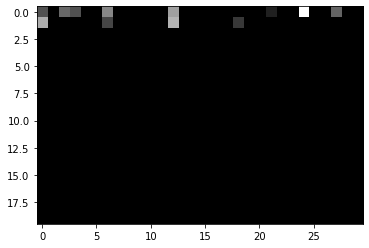

In [83]:
fin = final_im

plt.imshow(fin.cpu().detach().numpy(), cmap='gray')

In [84]:
optim = test.optimize()

TypeError: ignored